# We noted that all the benchmark data is zero. 

Lets see what is going on.

In [1]:
import icechunk
import xarray as xr

In [21]:
# self contained read that works on the hub (make sure to run the pip install before)
storage = icechunk.s3_storage(
    bucket='nasa-veda-scratch',
    prefix=f"jbusecke/nasa-waterinsight-test-full/", # TODO:change this depening on the final location 
    anonymous=False,
    from_env=True,
)

config = icechunk.RepositoryConfig.default()
config.set_virtual_chunk_container(
    icechunk.VirtualChunkContainer(
        "s3://nasa-waterinsight/NLDAS3/forcing/daily/",
        icechunk.s3_store(region='us-west-2')
    )
)

virtual_credentials = icechunk.containers_credentials(
    {
        # "s3://nasa-waterinsight/NLDAS3/forcing/daily/202201/": icechunk.s3_anonymous_credentials()
        "s3://nasa-waterinsight/NLDAS3/forcing/daily/": icechunk.s3_anonymous_credentials()
    }
)
    
repo = icechunk.Repository.open(
    storage=storage,
    config=config,
    authorize_virtual_chunk_access=virtual_credentials,
)

session = repo.readonly_session('main')
ds = xr.open_zarr(session.store, consolidated=False, zarr_version=3)
ds

/tmp/ipykernel_382900/1609769969.py:31: FutureWarning: zarr_version is deprecated, use zarr_format
  ds = xr.open_zarr(session.store, consolidated=False, zarr_version=3)
/home/jovyan/nldas-icechunk/.venv/lib/python3.12/site-packages/numcodecs/zarr3.py:145: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


<xarray.Dataset> Size: 51TB
Dimensions:   (time: 8399, lat: 6500, lon: 11700)
Coordinates:
  * time      (time) datetime64[ns] 67kB 2001-01-02 2001-01-03 ... 2024-01-01
  * lon       (lon) float64 94kB -169.0 -169.0 -169.0 ... -52.03 -52.01 -52.0
  * lat       (lat) float64 52kB 7.005 7.015 7.025 7.035 ... 71.97 71.98 71.99
Data variables:
    PSurf     (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Wind_E    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Wind_N    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Tair_max  (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    SWdown    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Qair      (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Tair_min  (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    LWdown    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Rainf     (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Tair      (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        daily
    shortname:              NLDAS_FOR0010_D_3.0
    title:                  NLDAS Forcing Data L4 Daily 0.01 x 0.01 degree V3...
    version:                3.0 beta
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/v3/ ; https://li...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  7.005000114440918
    SOUTH_WEST_CORNER_LON:  -168.9949951171875
    DX:                     0.009999999776482582
    DY:                     0.009999999776482582

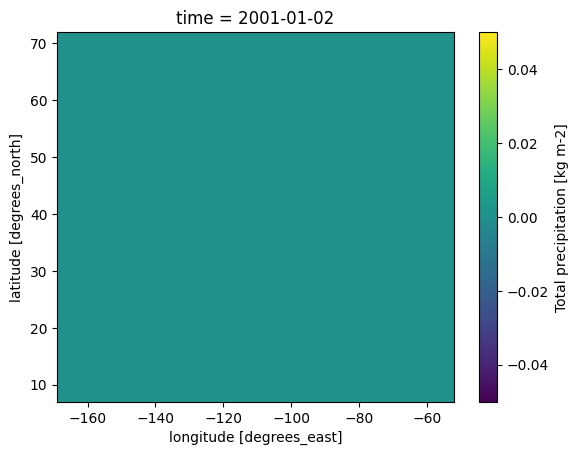

In [22]:
ds['Rainf'].isel(time=0).plot()

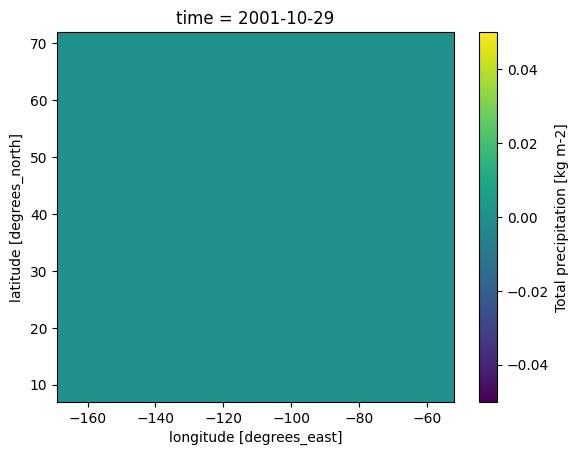

In [5]:
ds['Rainf'].isel(time=300).plot()

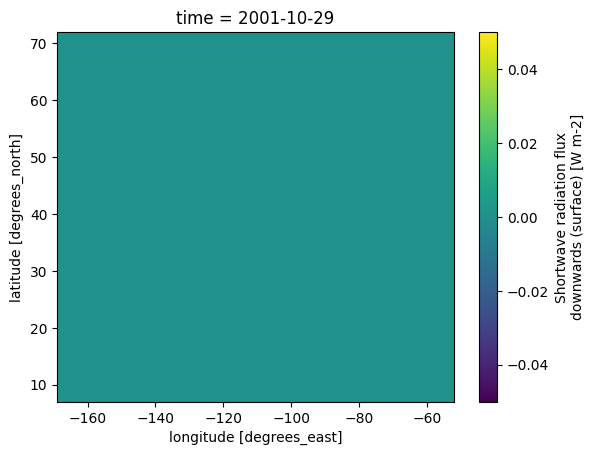

In [6]:
ds['SWdown'].isel(time=300).plot()

Well this is not great...lets see if this looks the same when we open the files directly

In [8]:
import fsspec
data_dir = "s3://nasa-waterinsight/NLDAS3/forcing/daily/"
# Use fsspec to list files in the S3 bucket
fs = fsspec.filesystem("s3", anon=True)
files = fs.glob(data_dir + "**/*.nc")
print(f"{len(files)} found")

8399 found


In [9]:
files[0:10]

['nasa-waterinsight/NLDAS3/forcing/daily/200101/NLDAS_FOR0010_D.A20010101.030.beta.nc',
 'nasa-waterinsight/NLDAS3/forcing/daily/200101/NLDAS_FOR0010_D.A20010102.030.beta.nc',
 'nasa-waterinsight/NLDAS3/forcing/daily/200101/NLDAS_FOR0010_D.A20010103.030.beta.nc',
 'nasa-waterinsight/NLDAS3/forcing/daily/200101/NLDAS_FOR0010_D.A20010104.030.beta.nc',
 'nasa-waterinsight/NLDAS3/forcing/daily/200101/NLDAS_FOR0010_D.A20010105.030.beta.nc',
 'nasa-waterinsight/NLDAS3/forcing/daily/200101/NLDAS_FOR0010_D.A20010106.030.beta.nc',
 'nasa-waterinsight/NLDAS3/forcing/daily/200101/NLDAS_FOR0010_D.A20010107.030.beta.nc',
 'nasa-waterinsight/NLDAS3/forcing/daily/200101/NLDAS_FOR0010_D.A20010108.030.beta.nc',
 'nasa-waterinsight/NLDAS3/forcing/daily/200101/NLDAS_FOR0010_D.A20010109.030.beta.nc',
 'nasa-waterinsight/NLDAS3/forcing/daily/200101/NLDAS_FOR0010_D.A20010110.030.beta.nc']

In [13]:
ds_file = xr.open_dataset("s3://"+files[0], engine='h5netcdf')

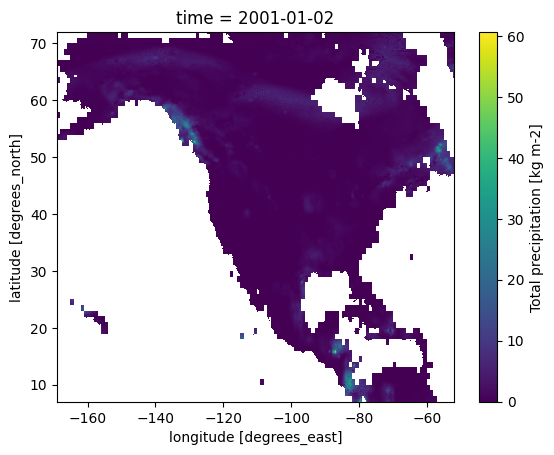

In [14]:
ds_file["Rainf"].plot()

## Wait is this an access issue? 

I just noticed that my virtual chunk container is pointing to a single month subfolder! If we can plot that specific months data, then this would point to some issue with the access.

In [19]:
ds_time_test = ds.sel(time='2022-01-15', method='nearest')

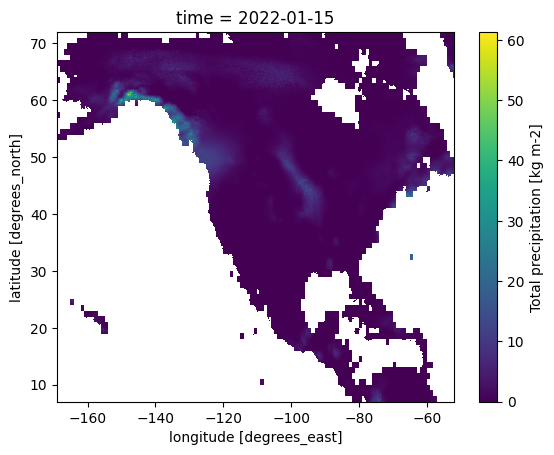

In [20]:
ds_time_test['Rainf'].plot()

In [ ]:
from virtualizarr import open_virtual_dataset